Breast tumour classification in PyTorch
=============================


In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
%matplotlib inline

Initial parameters
-------------------

In [2]:
# directory contains train and val folders with 8x class folders in each
data_dir = "C:/Users/Renee/Documents/2019/Semester 2/COMP5703/Data/breakhis"

num_classes = 8

# increase/decrease as memory allows
batch_size = 8

num_epochs = 10

# False to finetune the whole model. True to freeze and update only last layers
feature_extract = False

Choose from the following model types:
- `squeezenet1_0`: SqueezeNet 1.0 (architecture from paper)
- `squeezenet1_1`: SqueezeNet 1.1 (architecture from official repo)
- `resnet50`: ResNet50
- `vgg16_bn`: VGG16 with Batch Normalisation
- `inception_v3`: Inceptionv3
    

In [3]:
model_type = 'squeezenet1_0'

Model
-----

In [4]:
def train_model(model, model_type, dataloaders, criterion, optimizer, num_epochs=25):
    start = time.time()
    
    train_acc_history = []
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if model_type == 'inception_v3' and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                torch.save(model, model_type+'.pt')
                
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialise_model(num_classes, feature_extract, use_pretrained=True):

    # SqueezeNet 1.0 (from original paper)
    if model_type == "squeezenet1_0":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    # SqueezeNet 1.1 (from official repo)
    elif model_type == "squeezenet1_1":
        model_ft = models.squeezenet1_1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    
    # ResNet50
    elif model_type == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    # VGG16 with batch normalisation
    elif model_name == "vgg16_bn":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    # Inceptionv3
    elif model_name == "inception_v3":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    return model_ft, input_size

# Initialise model
model_ft, input_size = initialise_model(num_classes, feature_extract, use_pretrained=True)

print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

Load Data
---------


In [7]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

print("Initialising Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}        


Initialising Datasets and Dataloaders...


In [8]:
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train','val']}

# Send the model to GPU, if available
model_ft = model_ft.to(device)

# Select which parameters to learn
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

Training and Validation
--------------------------------


In [9]:
# Select loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_hist, val_hist = train_model(model_ft, model_type, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.0070 Acc: 0.2121
val Loss: 1.8804 Acc: 0.2750

Epoch 1/9
----------
train Loss: 1.7187 Acc: 0.3500
val Loss: 1.7840 Acc: 0.3000

Epoch 2/9
----------
train Loss: 1.6031 Acc: 0.3853
val Loss: 1.4680 Acc: 0.4937

Epoch 3/9
----------
train Loss: 1.3702 Acc: 0.4937
val Loss: 1.1742 Acc: 0.5521

Epoch 4/9
----------
train Loss: 1.2489 Acc: 0.5344
val Loss: 0.8336 Acc: 0.6687

Epoch 5/9
----------
train Loss: 1.1297 Acc: 0.5835
val Loss: 0.9269 Acc: 0.6271

Epoch 6/9
----------
train Loss: 1.0324 Acc: 0.6143
val Loss: 1.3191 Acc: 0.5135

Epoch 7/9
----------
train Loss: 0.9130 Acc: 0.6594
val Loss: 0.9285 Acc: 0.6479

Epoch 8/9
----------
train Loss: 0.8988 Acc: 0.6674
val Loss: 0.8070 Acc: 0.6917

Epoch 9/9
----------
train Loss: 0.8449 Acc: 0.6839
val Loss: 0.7483 Acc: 0.7083

Training complete in 6m 40s
Best val Acc: 0.708333


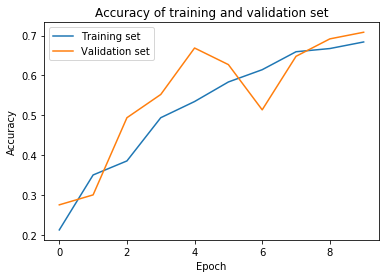

In [10]:
plt.plot(range(num_epochs), train_hist)
plt.plot(range(num_epochs), val_hist)
plt.title("Accuracy of training and validation set")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training set", "Validation set"])

Clear cache if you run into memory issues.

In [11]:
# import torch
# import gc
# #del model_ft
# gc.collect()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    

Model assessment
-----------------------------------

In [12]:
y_true, y_pred = [],[]

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().data.numpy())
        y_pred.extend(preds.cpu().data.numpy())

y_true = [image_datasets['train'].classes[i] for i in y_true]
y_pred = [image_datasets['train'].classes[i] for i in y_pred]

In [13]:
print('Overall accuracy: ' + str(round(accuracy_score(y_true, y_pred)*100,2)) + '%')
print('Balanced accuracy: ' + str(round(balanced_accuracy_score(y_true, y_pred)*100,2)) + '%')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_true,y_pred))
print('\n')
print(classification_report(y_true,y_pred))

Overall accuracy: 70.83%
Balanced accuracy: 70.83%


Confusion Matrix
[[ 94   7   9   0   0   3   7   0]
 [  1 102   4   1   0   2  10   0]
 [  4  45  59   0   0   1   4   7]
 [  0  11   0  79   4   0  21   5]
 [  0   3   3   0  84   7   4  19]
 [  5   0   0   0   5  81  28   1]
 [  4   0   0   0   0   4 108   4]
 [  0   0   0   1   2   7  37  73]]


              precision    recall  f1-score   support

         B_A       0.87      0.78      0.82       120
         B_F       0.61      0.85      0.71       120
        B_PT       0.79      0.49      0.61       120
        B_TA       0.98      0.66      0.79       120
        M_DC       0.88      0.70      0.78       120
        M_LC       0.77      0.68      0.72       120
        M_MC       0.49      0.90      0.64       120
        M_PC       0.67      0.61      0.64       120

    accuracy                           0.71       960
   macro avg       0.76      0.71      0.71       960
weighted avg       0.76      0.71      0.71       9